In [1]:
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm

from scipy import signal
from scipy.io import wavfile
from scipy.stats import pearsonr, zscore
from mne_bids import BIDSPath
from functools import partial
from nilearn.plotting import plot_markers

import torch
from torch import nn
import torchaudio
from transformers import WhisperProcessor, WhisperModel, AutoFeatureExtractor, AutoProcessor

/home/matteoc/miniconda3/envs/speech-meg/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda:6" if torch.cuda.is_available() else "cpu")

model = WhisperModel.from_pretrained("openai/whisper-base")
feature_extractor = AutoFeatureExtractor.from_pretrained("openai/whisper-base")
processor = AutoProcessor.from_pretrained("openai/whisper-base")
model.eval()

/home/matteoc/miniconda3/envs/speech-meg/lib/python3.9/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


WhisperModel(
  (encoder): WhisperEncoder(
    (conv1): Conv1d(80, 512, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv2): Conv1d(512, 512, kernel_size=(3,), stride=(2,), padding=(1,))
    (embed_positions): Embedding(1500, 512)
    (layers): ModuleList(
      (0-5): 6 x WhisperEncoderLayer(
        (self_attn): WhisperAttention(
          (k_proj): Linear(in_features=512, out_features=512, bias=False)
          (v_proj): Linear(in_features=512, out_features=512, bias=True)
          (q_proj): Linear(in_features=512, out_features=512, bias=True)
          (out_proj): Linear(in_features=512, out_features=512, bias=True)
        )
        (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (activation_fn): GELUActivation()
        (fc1): Linear(in_features=512, out_features=2048, bias=True)
        (fc2): Linear(in_features=2048, out_features=512, bias=True)
        (final_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      )


In [3]:
# PARAMS

bids_root = "/srv/nfs-data/sisko/storage/ECoG_podcast/ds005574-1.0.2" 
subject = '03'
func = partial(zscore, axis=1)
ecog_sr = 512
whisper_sr = 16000
pre_stimulus = 1.0
pre_audio = 0.2

## Get Data

In [4]:
def preprocess_raw_audio(audio_wave, fs):

    if audio_wave.ndim > 1:
        audio_wave = audio_wave.mean(axis=1)

    audio_wave = audio_wave.astype(np.float32)
    audio_wave_model = audio_wave / np.max(np.abs(audio_wave))

    return audio_wave_model

In [5]:
audio_path = f"{bids_root}/stimuli/podcast.wav"

audio_sf, audio_wave = wavfile.read(audio_path)
audio_wave_clean = preprocess_raw_audio(audio_wave, audio_sf)

/tmp/ipykernel_1818446/2770458045.py:3: WavFileWarning: Chunk (non-data) not understood, skipping it.
  audio_sf, audio_wave = wavfile.read(audio_path)


In [6]:
file_path = BIDSPath(root=bids_root+"/derivatives/ecogprep",
                     subject=subject,
                     task="podcast",
                     datatype="ieeg",
                     description="highgamma",
                     suffix="ieeg",
                     extension="fif")

In [7]:
transcript_path = f"{bids_root}/stimuli/podcast_transcript.csv"

df = pd.read_csv(transcript_path)
df.dropna(subset=['start'], inplace=True)
df.sort_values("start", inplace=True)
events = np.zeros((len(df), 3))
events[:, 0] = df.start

In [11]:
def get_stimuli_and_brain(file_path, audio_wave_clean, audio_sf, df, events, 
                          tmax=2.0, pre_audio=0.5, pre_stimulus=0.2,
                          model=None, processor=None, whisper_sr=16000,
                          device=device):
    
    model = model.to(device)

    raw = mne.io.read_raw_fif(file_path, verbose=False)
    raw.load_data(verbose=False)
    raw = raw.apply_function(func, channel_wise=False, verbose=False)

    epochs = mne.Epochs(
        raw,
        (events * raw.info['sfreq']).astype(int),
        tmin=-pre_stimulus,
        tmax=tmax,
        baseline=None,
        proj=None,
        event_id=None,
        preload=True,
        event_repeated="merge",
        verbose=False
    )
    good_idx = epochs.selection
    print(f"Epochs object has a shape of: {epochs._data.shape}")
    epochs = epochs.resample(sfreq=128, npad='auto', method='fft', window='hamming')
    epochs_snippet = epochs._data
    print(f"Epochs object after down-sampling has a shape of: {epochs_snippet.shape}")

    audio_snip_whisper = []
    for idx, row in tqdm.tqdm(enumerate(good_idx)):
        row = df.iloc[idx]
        start_sample = int((row['start']) * audio_sf) 
        end_sample = start_sample + int(tmax * audio_sf)
        snippet = audio_wave_clean[start_sample - int(pre_audio * audio_sf):end_sample]
        if len(snippet) < int(tmax * audio_sf):
            padding_len = int(tmax * audio_sf) - len(snippet)
            snippet = np.pad(snippet, (0, padding_len), mode='constant')
        snippet = torchaudio.transforms.Resample(audio_sf, whisper_sr)(torch.tensor(snippet).float())
        inputs = processor(snippet.squeeze(0), sampling_rate=whisper_sr, return_tensors="pt")
        input_features = inputs['input_features'].to(device)
        with torch.no_grad():
            outputs = model.encoder(input_features=input_features)
            hidden_states = outputs.last_hidden_state[:,:int(2*50*(tmax+pre_audio))]
            hidden_states = hidden_states[:,::2]   # sort of downsampling
            audio_snip_whisper.append(hidden_states.squeeze(0).cpu())
    audio_snip_whisper = torch.stack(audio_snip_whisper, dim=0)

    return epochs_snippet, audio_snip_whisper

In [12]:
brain_data, audio_data = get_stimuli_and_brain(file_path, audio_wave_clean, audio_sf, df, events, model=model, processor=processor)

Epochs object has a shape of: (5130, 235, 1127)
Epochs object after down-sampling has a shape of: (5130, 235, 282)


5130it [03:18, 25.87it/s]


In [87]:
audio_data.mean(), audio_data.std(), brain_data.mean(), brain_data.std()

(tensor(-0.0236), tensor(1.3550), 0.004692080188540864, 0.9196353568698805)

## Model

In [197]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = pe.unsqueeze(0)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)].to(x.device)

class AttentiveStim2BrainNet(nn.Module):
    def __init__(self, input_dim=512, output_channels=235, time_in=250, time_out=282, d_model=256, nhead=4, num_layers=4):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        self.pos_enc = PositionalEncoding(d_model, max_len=time_in)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        # self.norm = nn.LayerNorm(d_model)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.temporal_upsample = nn.Upsample(size=time_out, mode='linear', align_corners=True)

        self.cross_attention = nn.MultiheadAttention(embed_dim=d_model, num_heads=nhead, batch_first=True)
        self.output_proj = nn.Linear(d_model, output_channels)

    def forward(self, x):  # x: (batch, time_in=250, input_dim=512)
        x = self.input_proj(x)                          # (batch, 250, d_model)
        x = self.pos_enc(x)                             # Add position
        x = self.encoder(x)                             # Encode audio
        x = self.temporal_upsample(x.permute(0, 2, 1)).permute(0, 2, 1)  # (batch, 282, d_model)
        x_attn, _ = self.cross_attention(x, x, x)       # Self attention or cross-attention
        # x = self.norm(x_attn)
        x = self.output_proj(x_attn)                    # (batch, 282, output_channels)
        return x.permute(0, 2, 1)                       # (batch, 235, 282)


In [93]:
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch import nn, optim
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

brain_np = brain_data.reshape(5130, -1) 
brain_scaler = StandardScaler()

brain_std = torch.tensor(brain_np, dtype=torch.float32, device=device).reshape(5130, 235, 282)
stimuli = audio_data.to(device)

train_size = int(0.8 * len(stimuli))
val_size = int(0.1 * len(stimuli))
test_size = len(stimuli) - train_size - val_size

dataset = TensorDataset(stimuli, brain_std)
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))

batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)




In [245]:
model = AttentiveStim2BrainNet(d_model=128, nhead=2, num_layers=2).to(device)
mse_loss = nn.MSELoss()

def pearson_loss(pred, target, eps=1e-8):
    pred = pred - pred.mean(dim=-1, keepdim=True)
    target = target - target.mean(dim=-1, keepdim=True)
    corr_num = (pred * target).sum(dim=-1)
    corr_den = (pred.norm(dim=-1) * target.norm(dim=-1)).clamp(min=eps)
    corr = corr_num / corr_den
    return 1 - corr.mean()

def contrastive_loss(pred, target, tau=0.05):
    target = target.reshape(target.shape[0], -1)
    pred = pred.reshape(pred.shape[0], -1)   
    pred = F.normalize(pred, dim=1)   # (batch, 1)
    target = F.normalize(target, dim=1)
    sim_matrix = torch.mm(pred, target.T)   # (batch, batch)
    sim_matrix = sim_matrix / tau
    loss = -torch.log(torch.exp(torch.diag(sim_matrix)) / sim_matrix.exp().sum(dim=1))
    return loss.mean()

optimizer = optim.AdamW(model.parameters(), lr=1e-3, betas=(0.9, 0.95), weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5)

# Training loop
num_epochs = 50
best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        optimizer.zero_grad()
        y_pred = model(x)
        loss = 0.2 * mse_loss(y_pred, y.float()) + 0.8 * contrastive_loss(y_pred, y.float())
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * x.size(0)

    train_loss /= len(train_loader.dataset)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            val_loss += (0.2 * mse_loss(y_pred, y) + 0.8 * contrastive_loss(y_pred, y)) * x.size(0)
    val_loss /= len(val_loader.dataset)
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Salva il modello migliore
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "/home/matteoc/ecog-speech/best_model_CL.pt")


Epoch 1/50:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch 1/50: 100%|██████████| 129/129 [00:00<00:00, 164.88it/s]


Epoch 1, Train Loss: 2.4170, Val Loss: 2.0298


Epoch 2/50: 100%|██████████| 129/129 [00:01<00:00, 102.29it/s]


Epoch 2, Train Loss: 1.7994, Val Loss: 1.6906


Epoch 3/50: 100%|██████████| 129/129 [00:01<00:00, 97.41it/s]


Epoch 3, Train Loss: 1.4869, Val Loss: 1.4441


Epoch 4/50: 100%|██████████| 129/129 [00:01<00:00, 95.45it/s]


Epoch 4, Train Loss: 1.2276, Val Loss: 1.2228


Epoch 5/50: 100%|██████████| 129/129 [00:01<00:00, 93.88it/s]


Epoch 5, Train Loss: 0.9990, Val Loss: 1.0214


Epoch 6/50: 100%|██████████| 129/129 [00:01<00:00, 97.52it/s]


Epoch 6, Train Loss: 0.8084, Val Loss: 0.9130


Epoch 7/50: 100%|██████████| 129/129 [00:01<00:00, 96.20it/s]


Epoch 7, Train Loss: 0.6851, Val Loss: 0.7764


Epoch 8/50: 100%|██████████| 129/129 [00:01<00:00, 99.87it/s]


Epoch 8, Train Loss: 0.5942, Val Loss: 0.7127


Epoch 9/50: 100%|██████████| 129/129 [00:01<00:00, 96.03it/s]


Epoch 9, Train Loss: 0.5297, Val Loss: 0.6406


Epoch 10/50: 100%|██████████| 129/129 [00:01<00:00, 97.39it/s]


Epoch 10, Train Loss: 0.4776, Val Loss: 0.5876


Epoch 11/50: 100%|██████████| 129/129 [00:01<00:00, 97.47it/s]


Epoch 11, Train Loss: 0.4366, Val Loss: 0.5419


Epoch 12/50: 100%|██████████| 129/129 [00:01<00:00, 96.89it/s]


Epoch 12, Train Loss: 0.4123, Val Loss: 0.5106


Epoch 13/50: 100%|██████████| 129/129 [00:01<00:00, 97.33it/s]


Epoch 13, Train Loss: 0.3822, Val Loss: 0.4860


Epoch 14/50: 100%|██████████| 129/129 [00:01<00:00, 94.31it/s]


Epoch 14, Train Loss: 0.3632, Val Loss: 0.4667


Epoch 15/50: 100%|██████████| 129/129 [00:01<00:00, 98.22it/s]


Epoch 15, Train Loss: 0.3459, Val Loss: 0.4458


Epoch 16/50: 100%|██████████| 129/129 [00:01<00:00, 96.18it/s]


Epoch 16, Train Loss: 0.3283, Val Loss: 0.4222


Epoch 17/50: 100%|██████████| 129/129 [00:01<00:00, 83.26it/s]


Epoch 17, Train Loss: 0.3162, Val Loss: 0.4144


Epoch 18/50: 100%|██████████| 129/129 [00:01<00:00, 97.88it/s]


Epoch 18, Train Loss: 0.3038, Val Loss: 0.4048


Epoch 19/50: 100%|██████████| 129/129 [00:01<00:00, 114.97it/s]


Epoch 19, Train Loss: 0.2944, Val Loss: 0.3860


Epoch 20/50: 100%|██████████| 129/129 [00:00<00:00, 141.84it/s]


Epoch 20, Train Loss: 0.2876, Val Loss: 0.3722


Epoch 21/50: 100%|██████████| 129/129 [00:01<00:00, 100.86it/s]


Epoch 21, Train Loss: 0.2780, Val Loss: 0.3569


Epoch 22/50: 100%|██████████| 129/129 [00:01<00:00, 99.96it/s]


Epoch 22, Train Loss: 0.2713, Val Loss: 0.3509


Epoch 23/50: 100%|██████████| 129/129 [00:01<00:00, 96.23it/s]


Epoch 23, Train Loss: 0.2642, Val Loss: 0.3496


Epoch 24/50: 100%|██████████| 129/129 [00:01<00:00, 98.69it/s]


Epoch 24, Train Loss: 0.2595, Val Loss: 0.3431


Epoch 25/50: 100%|██████████| 129/129 [00:01<00:00, 94.58it/s]


Epoch 25, Train Loss: 0.2549, Val Loss: 0.3255


Epoch 26/50: 100%|██████████| 129/129 [00:01<00:00, 95.55it/s]


Epoch 26, Train Loss: 0.2493, Val Loss: 0.3185


Epoch 27/50: 100%|██████████| 129/129 [00:01<00:00, 97.56it/s]


Epoch 27, Train Loss: 0.2462, Val Loss: 0.3211


Epoch 28/50: 100%|██████████| 129/129 [00:01<00:00, 100.74it/s]


Epoch 28, Train Loss: 0.2419, Val Loss: 0.3139


Epoch 29/50: 100%|██████████| 129/129 [00:01<00:00, 97.80it/s]


Epoch 29, Train Loss: 0.2377, Val Loss: 0.3051


Epoch 30/50: 100%|██████████| 129/129 [00:01<00:00, 97.66it/s]


Epoch 30, Train Loss: 0.2348, Val Loss: 0.2978


Epoch 31/50: 100%|██████████| 129/129 [00:01<00:00, 95.22it/s]


Epoch 31, Train Loss: 0.2312, Val Loss: 0.2986


Epoch 32/50: 100%|██████████| 129/129 [00:01<00:00, 103.03it/s]


Epoch 32, Train Loss: 0.2287, Val Loss: 0.2903


Epoch 33/50: 100%|██████████| 129/129 [00:01<00:00, 94.44it/s]


Epoch 33, Train Loss: 0.2272, Val Loss: 0.2894


Epoch 34/50: 100%|██████████| 129/129 [00:01<00:00, 98.93it/s]


Epoch 34, Train Loss: 0.2232, Val Loss: 0.2814


Epoch 35/50: 100%|██████████| 129/129 [00:01<00:00, 96.64it/s]


Epoch 35, Train Loss: 0.2223, Val Loss: 0.2806


Epoch 36/50: 100%|██████████| 129/129 [00:01<00:00, 100.41it/s]


Epoch 36, Train Loss: 0.2206, Val Loss: 0.2750


Epoch 37/50: 100%|██████████| 129/129 [00:01<00:00, 93.60it/s]


Epoch 37, Train Loss: 0.2178, Val Loss: 0.2731


Epoch 38/50: 100%|██████████| 129/129 [00:01<00:00, 95.76it/s]


Epoch 38, Train Loss: 0.2153, Val Loss: 0.2686


Epoch 39/50: 100%|██████████| 129/129 [00:01<00:00, 98.03it/s]


Epoch 39, Train Loss: 0.2133, Val Loss: 0.2669


Epoch 40/50: 100%|██████████| 129/129 [00:01<00:00, 97.01it/s]


Epoch 40, Train Loss: 0.2120, Val Loss: 0.2617


Epoch 41/50: 100%|██████████| 129/129 [00:01<00:00, 96.15it/s]


Epoch 41, Train Loss: 0.2111, Val Loss: 0.2635


Epoch 42/50: 100%|██████████| 129/129 [00:01<00:00, 100.41it/s]


Epoch 42, Train Loss: 0.2093, Val Loss: 0.2608


Epoch 43/50: 100%|██████████| 129/129 [00:01<00:00, 97.67it/s]


Epoch 43, Train Loss: 0.2069, Val Loss: 0.2581


Epoch 44/50: 100%|██████████| 129/129 [00:01<00:00, 95.99it/s]


Epoch 44, Train Loss: 0.2056, Val Loss: 0.2544


Epoch 45/50: 100%|██████████| 129/129 [00:01<00:00, 98.63it/s]


Epoch 45, Train Loss: 0.2051, Val Loss: 0.2539


Epoch 46/50: 100%|██████████| 129/129 [00:01<00:00, 95.59it/s]


Epoch 46, Train Loss: 0.2032, Val Loss: 0.2518


Epoch 47/50: 100%|██████████| 129/129 [00:01<00:00, 98.58it/s]


Epoch 47, Train Loss: 0.2023, Val Loss: 0.2468


Epoch 48/50: 100%|██████████| 129/129 [00:01<00:00, 95.14it/s]


Epoch 48, Train Loss: 0.2007, Val Loss: 0.2461


Epoch 49/50: 100%|██████████| 129/129 [00:01<00:00, 98.10it/s]


Epoch 49, Train Loss: 0.2003, Val Loss: 0.2408


Epoch 50/50: 100%|██████████| 129/129 [00:01<00:00, 94.24it/s]

Epoch 50, Train Loss: 0.1986, Val Loss: 0.2418


In [246]:
# Valutazione finale su test set
model.load_state_dict(torch.load("/home/matteoc/ecog-speech/best_model_CL.pt"))
model.eval()
test_loss = 0
y_pred_all = []
y_true_all = []
with torch.no_grad():
    for x, y in test_loader:
        y_pred = model(x)
        y_pred_all.append(y_pred.cpu())
        y_true_all.append(y.cpu())
        test_loss += (0.2 * mse_loss(y_pred, y) + 0.8 * contrastive_loss(y_pred, y)) * x.size(0)
y_pred_all = torch.cat(y_pred_all, dim=0)
y_true_all = torch.cat(y_true_all, dim=0)
test_loss /= len(test_loader.dataset)
print(f"Test Loss: {test_loss:.4f}")

Test Loss: 0.2492


In [247]:
from torchmetrics.functional import pearson_corrcoef

correlations_time = np.zeros((y_pred_all.shape[0], y_pred_all.shape[2]))
for sample in tqdm(range(y_pred_all.shape[0])):
    y_pred_sample = y_pred_all[sample, :, :]
    y_true_sample = y_true_all[sample, :, :]
    for tp in range(y_pred_all.shape[2]):
        pred = y_pred_sample[:, tp]
        target = y_true_sample[:, tp]
        corr = pearson_corrcoef(pred, target)
        correlations_time[sample, tp] = corr.item()

100%|██████████| 513/513 [00:12<00:00, 42.57it/s]


In [248]:
correlations_time = np.mean(correlations_time, axis=0)

In [249]:
from torchmetrics.functional import pearson_corrcoef

correlations_channels = np.zeros((y_pred_all.shape[0], y_pred_all.shape[1]))
for sample in tqdm(range(y_pred_all.shape[0])):
    y_pred_sample = y_pred_all[sample, :, :]
    y_true_sample = y_true_all[sample, :, :]
    for channel in range(y_pred_all.shape[1]):
        pred = y_pred_sample[channel, :]
        target = y_true_sample[channel, :]
        corr = pearson_corrcoef(pred, target)
        correlations_channels[sample, channel] = corr.item()

100%|██████████| 513/513 [00:09<00:00, 52.05it/s]


In [250]:
correlations_channels = np.mean(correlations_channels, axis=0)

In [251]:
correlations_channels.max(), correlations_channels.mean(), correlations_channels.min(), correlations_channels.std()

(0.603262339956463,
 0.21871998465788992,
 0.03905444850109892,
 0.1264038527232316)

In [252]:
correlations_time.max(), correlations_time.mean(), correlations_time.min(), correlations_time.std()

(0.29088860470892364,
 0.27043696144826784,
 0.1803533300917621,
 0.01759919675432372)

In [255]:
# lags = np.linspace(-1, 2, 282) 
# mean = correlations_time

# fig, ax = plt.subplots()
# ax.plot(lags, mean, color='black')
# ax.fill_between(lags, mean, mean, alpha=0.2, color='black')
# ax.set_xlabel("lag (s)")
# ax.set_ylabel("encoding performance (r ± sem)")
# ax.axvline(0, c=(.9, .9, .9), ls="--")
# ax.axhline(0, c=(.9, .9, .9), ls="--")
# fig.show()

Coordinate matrix shape:  (235, 3)


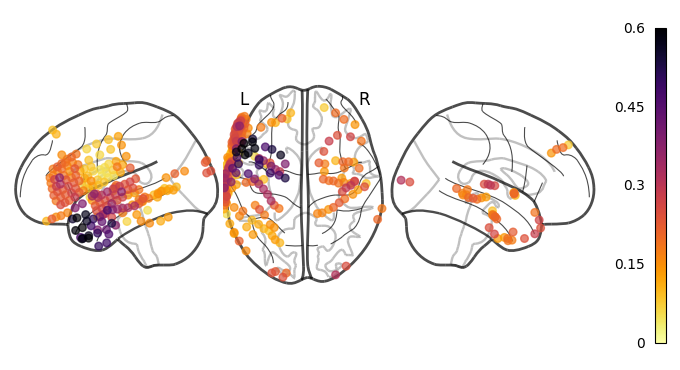

In [254]:
raw = mne.io.read_raw_fif(file_path, verbose=False)
raw.load_data(verbose=False)
raw = raw.apply_function(func, channel_wise=False, verbose=False)

ch2loc = {ch['ch_name']: ch['loc'][:3] for ch in raw.info['chs']}
coords = np.vstack([ch2loc[ch] for ch in raw.info['ch_names']])
coords *= 1000  # nilearn likes to plot in meters, not mm
print("Coordinate matrix shape: ", coords.shape)

order = correlations_channels.argsort()
plot_markers(correlations_channels[order], coords[order],
             node_size=30, display_mode='lzr',
             node_vmin=0, node_cmap='inferno_r', colorbar=True)
plt.show()